<font size="6">Clustering of C-AFM data </font>

<font size="4">1. Introduction </font>

This notebook describes the typical clustering routine for experimental data recieved from Conductive Atomic Force Microscopy (C-AFM) experiment. 

First, we should explain what C-AFM is. This technique stems from the base Atomic Force Microscopy (AFM). The AFM was invented by IBM scientists in 1985. It allows to image and investigate samples on a very small scale (at order of nanometers, 1E-9 m) by using a very sharp tip (with the tip apex radius in the order of 10 nm).

C-AFM is derived from AFM: in this particular technique the tip is electrically conductive (as well as the substrate) and is kept in contact with the sample. Electric field is applied between the substrate and the tip to the sample between them which allows an electric current to flow through the sample (see the Figure below).

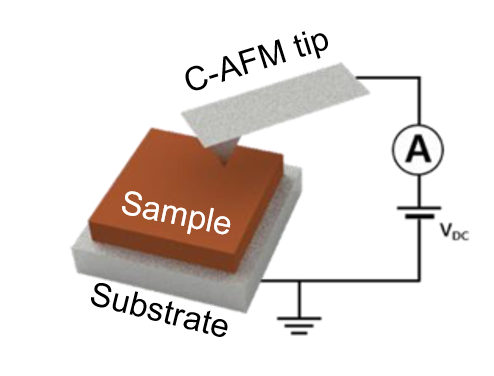

This technique is a powerfull tool for material research and it attracts particular interest in semiconductor research field. It allows to study electrical properties of materials on a very small (nanometric) scale which is of importance in the context of constant minituarization of the electronic components (state-of-the-art transistor technology already passed below 10 nm).

<font size="4">2. Motivation for ML approach </font>

With the progress in hardware and software components of AFM instruments, it has become usual to acquire large datasets during a measurement session (thousands of current - voltage characteristics in case of C-AFM).

The acquisition is usually performed in the following manner: the tip lands in the region of interest of the sample, and measuremnts are performed in a grid with a fixed step: for example, 20 x 20 grid with a step of 10 nm generates 400 current - voltage curves for a surface of 200 x 200 nm$^{2}$. It is important to note that during these measurements no imaging is performed.

The dataset in this notebook is compiled from 4 measurements: two 10 x 10 grids and two 20 x 20 grids, all with a step of 10 nm; 1000 measurement points in total. The sample is MoS$_{2}$ monolayer treated with oxygen plasma. This treatment results in the apparition of defects which promote conductivity as we will see further in the data.

It is not unusual to have thousands of experimental curves after one day of measurements and sorting them by hand does not seem feasible in a resonable ammount of time. The C-AFM measurement procedure is very delicate and time consuming on its own.

With the widespread of ML in recent years, it is of interest to apply ML clustering algorithms to this task in order to help with data treatment since it allows to obtain results significantly faster and in a more reproducible manner.

<font size="4">3. Data clustering </font>

First, we install the missing packages:

In [ ]:
# conda install -c conda-forge kneed #Install kneed
# conda install -c conda-forge umap-learn

After that, we import the packages we will be using:

In [2]:
import numpy as np
import scipy.signal
from pathlib import Path
import pandas as pd
from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap

import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

<font size="3">3.1 Download the data </font>

Then we proceed to load the data. In this example, the data is already converted from its binary form (by using the [following script](https://github.com/kkn1993/C-AFM-and-SThM-scripts/blob/master/IV_matrix_constructor.py)) and is compiled in a text file with columns corresponding to the voltage and current:

In [3]:
url = 'https://www.dropbox.com/s/acy9ief178m66hj/test.txt?dl=1'
#data_folder = Path("C:/Users/kirill.kondratenko/Documents/MATLAB/cluster")
#file_to_open = data_folder / 'temp.txt'#"SPI-FC-hysteresis.txt"#"SPI-FC-hysteresis.txt"

data = pd.read_csv(url, sep="\t", header = None)

Visualise the top rows of the data. Note the dimensions of the dataset: each of the 1000 measurement points provides 4 columns of the data: voltage, forward current, voltage, backward current.

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,-2.00000,-5.493750e-07,-2.00000,-5.472000e-07,-2.00000,-7.500000e-10,-2.00000,-3.750000e-11,-2.00000,-7.500000e-10,...,-2.00000,-5.467880e-07,-2.00000,-5.467500e-07,-2.00000,-5.467880e-07,-2.00000,-5.467500e-07,-2.00000,-5.467880e-07
1,-1.99217,-4.860370e-07,-1.99217,-5.472000e-07,-1.99217,-3.750000e-11,-1.99217,-3.750000e-11,-1.99217,-3.750000e-11,...,-1.99217,-5.467880e-07,-1.99217,-5.467130e-07,-1.99217,-5.467880e-07,-1.99217,-5.467130e-07,-1.99217,-5.467880e-07
2,-1.98434,-4.594880e-07,-1.98434,-5.472380e-07,-1.98434,-3.750000e-11,-1.98434,-3.750000e-11,-1.98434,-3.750000e-11,...,-1.98434,-5.467880e-07,-1.98434,-5.467130e-07,-1.98434,-5.467880e-07,-1.98434,-5.467130e-07,-1.98434,-5.467880e-07
3,-1.97652,-4.275750e-07,-1.97652,-5.472380e-07,-1.97652,-3.750000e-11,-1.97652,-3.750000e-11,-1.97652,-3.750000e-11,...,-1.97652,-5.467880e-07,-1.97652,-5.467130e-07,-1.97652,-5.467880e-07,-1.97652,-5.467130e-07,-1.97652,-5.467880e-07
4,-1.96869,-4.048500e-07,-1.96869,-5.472000e-07,-1.96869,-3.750000e-11,-1.96869,-3.750000e-11,-1.96869,-3.750000e-11,...,-1.96869,-5.467880e-07,-1.96869,-5.467130e-07,-1.96869,-5.467880e-07,-1.96869,-5.467130e-07,-1.96869,-5.467880e-07


Reshape the data to retrieve only current vectors and put the in a dedicated array:

In [22]:
voltage = data.iloc[:, 0].values
current_up = data.iloc[:, 1::4].values
current_down = data.iloc[:, 3::4].values
current_all = np.concatenate((current_up, current_down), axis = 1)


numVoltage = len(voltage)

N_spectra = current_up.shape[1]

numX = 10 
numY = N_spectra//numX 

data_idx_up = np.arange(1, N_spectra+1)
data_idx_up = np.reshape(data_idx_up, (numY, numX))

data_mapI_up = np.reshape(current_up, (numVoltage, numY, numX))
data_mapI_up = np.transpose(data_mapI_up, (1, 2, 0))

data_mapI_down = np.reshape(current_down, (numVoltage, numY, numX))
data_mapI_down = np.transpose(data_mapI_down, (1, 2, 0))

In [6]:
current_all.shape

(512, 2000)

<font size="3">3.2 Visualize the data </font>

Plot first 200 current vectors. Note how widely distributed the data is - sorting it by hand will take quite a lot of time.

<ipython-input-7-475b116efda2>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(voltage, np.log10(np.abs(current_all[:, 0:199])))


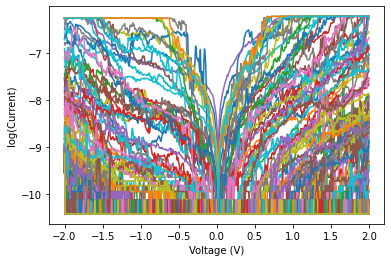

In [7]:
plt.plot(voltage, np.log10(np.abs(current_all[:, 0:199])))
plt.xlabel('Voltage (V)')
plt.ylabel('log(Current)')
plt.show()

To better visualise the distribution of electrical current values, extract the slices at given voltage values (BIAS) and compile waffle charts:

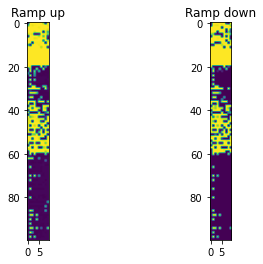

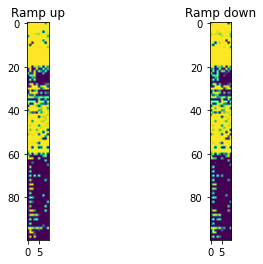

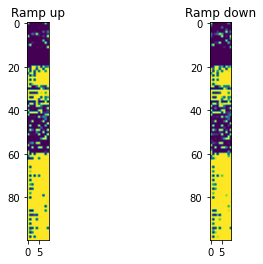

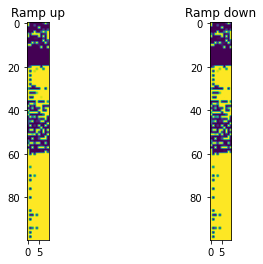

In [8]:
BIAS = [-2, -1, 1, 2]

for bias_i in BIAS:
    Bias_idx = np.where(min(abs(bias_i - voltage)) == abs(bias_i - voltage))[0]
    
    #Bias_idx=511

    fig, ax = plt.subplots(1, 2)
    
    ax[0].imshow(data_mapI_up[:,:,Bias_idx]) #,extent=[0, 1, 0, 1]
    ax[0].set_title('Ramp up')
    ax[1].imshow(data_mapI_down[:,:,Bias_idx])
    ax[1].set_title('Ramp down')

<font size="3">3.3 Reduce the dimensionality with UMAP </font>

UMAP (Uniform Manifold Approximation & Projection) dimensionality reduction algorithm has demonstrated the best results for C-AFM data [1].

<font size="1">[1] EL ABBASSI, Maria, OVERBECK, Jan, BRAUN, Oliver, et al. Benchmark and application of unsupervised classification approaches for univariate data. Communications Physics, 2021, vol. 4, no 1, p. 1-9. </font>

We perform the reduction with UMAP from 512 dimensions to 3:


C:\Users\kirill.kondratenko\Anaconda3\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 0.92, 'UMAP projection')

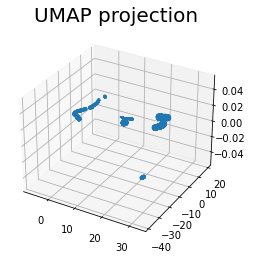

In [9]:
#data_to_reduce = current_up.T
#data_to_reduce = current_all.T
data_to_reduce = deepcopy(current_all.T)
np.random.shuffle(data_to_reduce)


reducer = umap.UMAP(n_epochs = 1000, metric='cosine', n_neighbors=20, n_components=3)
scaled_current_up_data = StandardScaler().fit_transform(data_to_reduce)

embedding = reducer.fit_transform(scaled_current_up_data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    embedding[:, 2]
    )
plt.gca().set_aspect('auto', 'datalim')
plt.title('UMAP projection', fontsize=20)

<font size="3">3.4 Perform clustering of the data </font>

We use K-Means clustering algorithm since it performs reasonably well on sparse data, as in contrast to other popular choices like DBSCAN.

In [10]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(embedding)
    wcss.append(kmeans.inertia_)
#plt.plot(range(1, 20), wcss)
#plt.title('Elbow Method')
#plt.xlabel('Number of clusters')
#plt.ylabel('WCSS')
#plt.show()


We find the optimal number of clusters with the elbow method:

Number of clusters from elbow method: 4


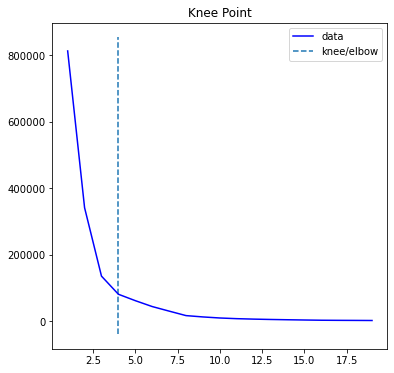

In [11]:
#Optimal number of clusters
kneedle = KneeLocator(range(1, 20), wcss, S=1.0, curve="convex", direction="decreasing")
kneedle.plot_knee()

N_clusters = round(kneedle.elbow, 0)
print('Number of clusters from elbow method:', N_clusters)
#N_clusters = 7

We cluster the data with previously obtained number of clusters and plot the distribution:

C:\Users\kirill.kondratenko\Anaconda3\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


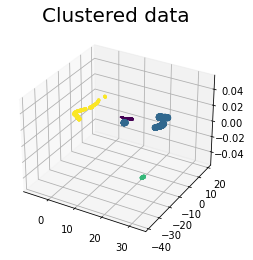

In [12]:
kmeans = KMeans(n_clusters=N_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(embedding)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    embedding[:, 2],
    c=pred_y
    )
#plt.scatter(embedding[:,0], embedding[:,1], embedding[:, 2], c=pred_y)
plt.gca().set_aspect('auto', 'datalim')
plt.title('Clustered data', fontsize=20)
plt.show()

<font size="3">3.5 Explore the clustered data </font>

We plot the average current - voltage curve to see what clusters were picked by the algorithm. The graph legend corresponds to the number of the cluster as well as the fraction of this cluster in the whole dataset.

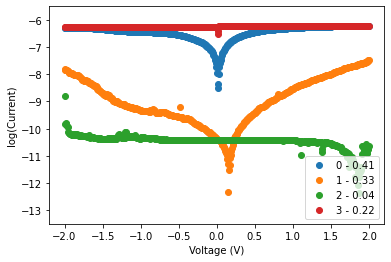

In [13]:
av_clusters = np.zeros((512, N_clusters))
clust_dict = {}
clust_fraction = []
for n in range(N_clusters):
    idx = np.where(pred_y == n)
    current_cluster = data_to_reduce[idx].T
    clust_fraction.append(current_cluster.shape[1]/data_to_reduce.T.shape[1])
    clust_dict[n] = current_cluster
    av_cluster = np.mean(current_cluster, axis = 1)
    av_clusters[:,n] = av_cluster
#plt.plot(voltage, np.abs(av_clusters))
labels = np.arange(0, N_clusters)
for av_cluster, label in zip(av_clusters.T, labels):
    plt.scatter(voltage, np.log10(np.abs(av_cluster)), label = str(label) +' - ' + f'{clust_fraction[label]:.2f}')
plt.xlabel('Voltage (V)')
plt.ylabel('log(Current)')
plt.ylim([-13.5, -5.5])
plt.legend(loc = 'lower right')
plt.show()

We select the cluster of interest from *clust_dict* and plot the data corresponding to it. Note how the data in this clusteris significantly more homogeneous than in the initial dataset.

<ipython-input-14-634adc98bb7f>:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(voltage, np.log10(np.abs(clust_dict[COI])))


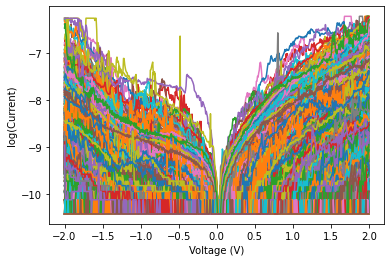

In [14]:
COI = 1 #cluster of interest
#for ramp in clust_dict[COI].T:
#    plt.plot(voltage, np.log10(np.abs(ramp+1e-12)))
plt.plot(voltage, np.log10(np.abs(clust_dict[COI])))
plt.xlabel('Voltage (V)')
plt.ylabel('log(Current)')
plt.show()

We plot the average currernt - voltage curve in linear scale:

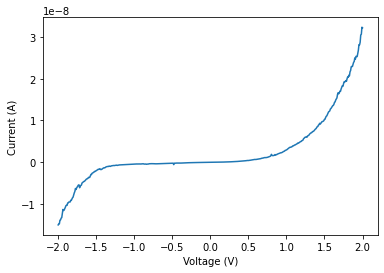

In [15]:
av_ramp = np.mean(clust_dict[COI], axis = 1)
plt.plot(voltage, av_ramp)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.show()

We also plot the first derivative of the averaged curve to extract energy levels of the material. From this data, we see that the band gap of the material is close to 1.9 eV which corresponds to MoS$_{2}$ monolayer in its pristine form.

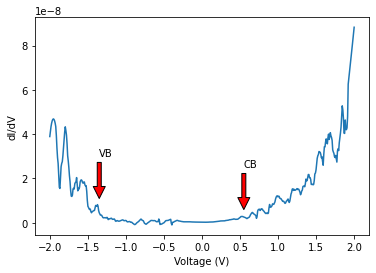

In [21]:
dI_dV = np.gradient(av_ramp)/np.gradient(voltage) #differentiate to get dI/dV
dI_dV_smoothed = scipy.signal.savgol_filter(dI_dV, 21, 2)
plt.plot(voltage, dI_dV_smoothed)
plt.xlabel('Voltage (V)')
plt.ylabel('dI/dV')
plt.annotate('VB', xy =(-1.35, 1e-8),
                xytext =(-1.35, 3e-8), 
                arrowprops = dict(facecolor ='red',
                                  shrink = 0.05),)
plt.annotate('CB', xy =(0.55, 0.5e-8),
                xytext =(0.55, 2.5e-8), 
                arrowprops = dict(facecolor ='red',
                                  shrink = 0.05),)
  
plt.show()

<font size="4">4. Conclusion </font>

  In this notebook we have demonstrated how ML can be applied to routine tasks in semiconductor research data treatment and how it can speed up the process of material characterisation. From our data we were able to determine 4 clusters, corresponding to varying sample behaviour: non-conductive, possibly due to contact problems, highly conductive behaviour which is explained by the absence of material (tip is landed on highly conductive substrate instead of the sample) as well as 2 other types of behaviour releated to the sample itself: pristine (lower conductance, about 40% of the data corresponding to the sample) and plasma-treated (higher conductance, about 60%). 